<a href="https://colab.research.google.com/github/k953/HTMLfile/blob/main/Amazon_Product_Review_Sentiment_Analysis_using_RNN_and_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Lambda
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM, SimpleRNN, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Conv1D
from tensorflow.keras import backend as K


In [19]:
# Load csv file
df = pd.read_csv('/content/Amazon_Unlocked_Mobile.csv')
df.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0


In [20]:
print("Summary statistics of numerical features : \n", df.describe())

print("\nTotal number of reviews: ",len(df))
print("\nTotal number of brands: ", len(list(set(df['Brand Name']))))
print("\nTotal number of unique products: ", len(list(set(df['Product Name']))))

print("\nPercentage of reviews with neutral sentiment : {:.2f}%"\
      .format(df[df['Rating']==3]["Reviews"].count()/len(df)*100))
print("\nPercentage of reviews with positive sentiment : {:.2f}%"\
      .format(df[df['Rating']>3]["Reviews"].count()/len(df)*100))
print("\nPercentage of reviews with negative sentiment : {:.2f}%"\
      .format(df[df['Rating']<3]["Reviews"].count()/len(df)*100))




Summary statistics of numerical features : 
                Price         Rating   Review Votes
count  164005.000000  166646.000000  161437.000000
mean      253.408993       3.841448       1.494465
std       343.052125       1.556175       9.482999
min         2.290000       1.000000       0.000000
25%        79.990000       3.000000       0.000000
50%       135.000000       5.000000       0.000000
75%       265.000000       5.000000       1.000000
max      2598.000000       5.000000     487.000000

Total number of reviews:  166646

Total number of brands:  92

Total number of unique products:  1126

Percentage of reviews with neutral sentiment : 6.93%

Percentage of reviews with positive sentiment : 69.70%

Percentage of reviews with negative sentiment : 23.35%


Text(0, 0.5, 'Count')

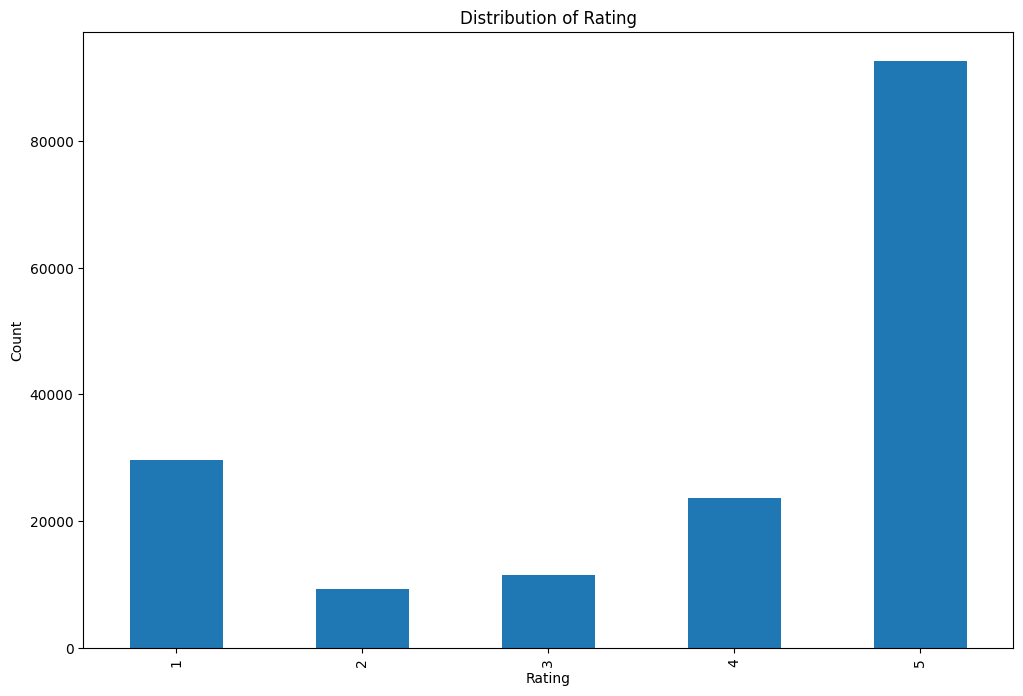

In [21]:
# Plot distribution of rating
plt.figure(figsize=(12,8))
# sns.countplot(df['Rating'])
df['Rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Rating')
plt.xlabel('Rating')
plt.ylabel('Count')


Text(0.5, 1.0, 'Number of Reviews for Top 20 Brands')

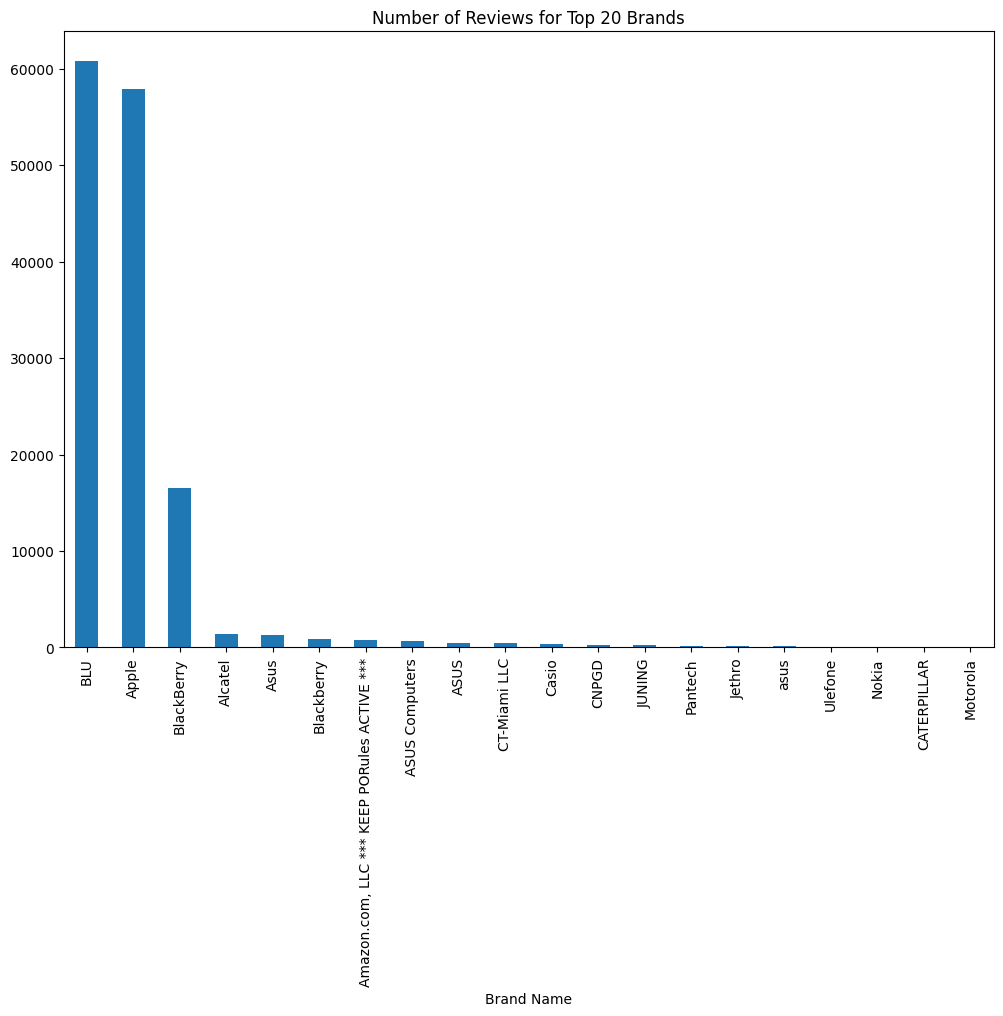

In [22]:
# Plot number of reviews for top 20 brands
brands = df["Brand Name"].value_counts()
# brands.count()
plt.figure(figsize=(12,8))
brands[:20].plot(kind='bar')
plt.title("Number of Reviews for Top 20 Brands")

Text(0.5, 1.0, 'Number of Reviews for Top 50 Products')

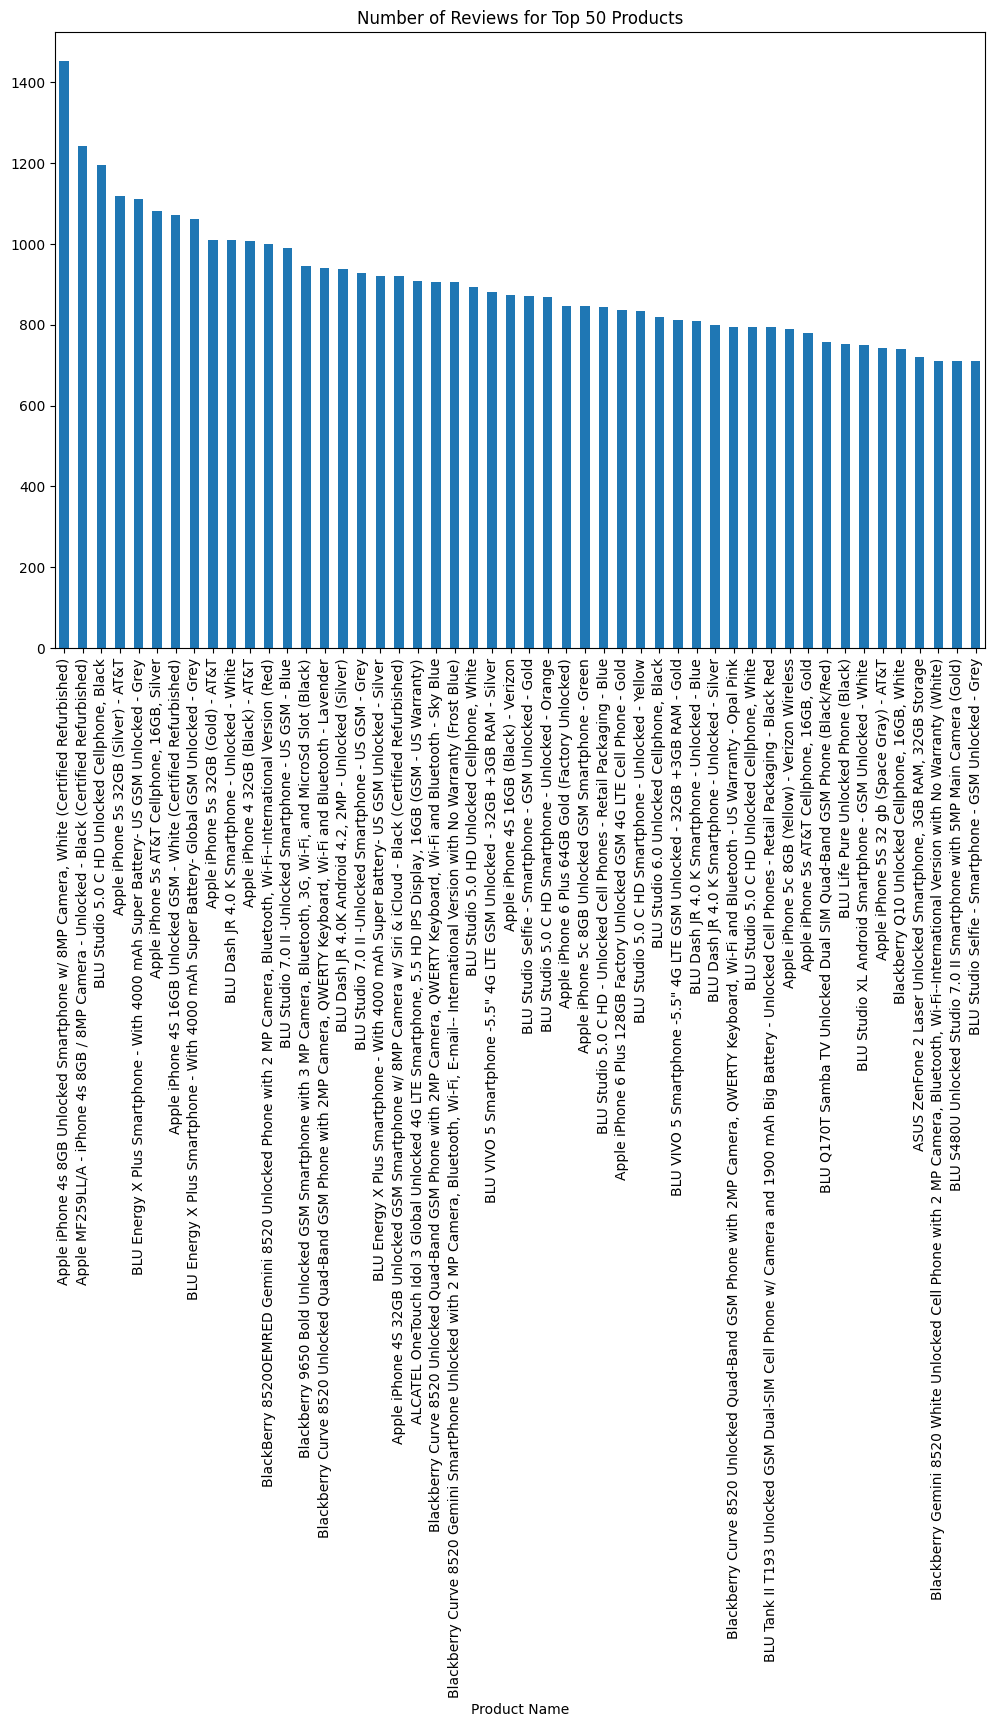

In [23]:
# Plot number of reviews for top 50 products
products = df["Product Name"].value_counts()
plt.figure(figsize=(12,8))
products[:50].plot(kind='bar')
plt.title("Number of Reviews for Top 50 Products")

Text(0, 0.5, 'Count')

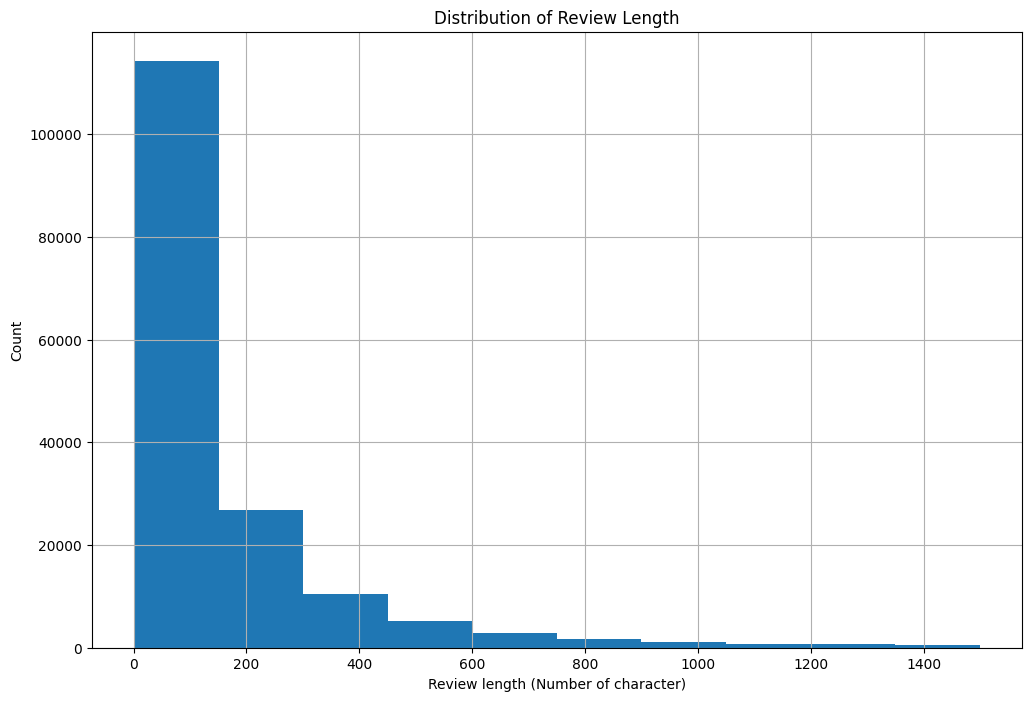

In [24]:
# Plot distribution of review length
review_length = df["Reviews"].dropna().map(lambda x: len(x))
plt.figure(figsize=(12,8))
review_length.loc[review_length < 1500].hist()
plt.title("Distribution of Review Length")
plt.xlabel('Review length (Number of character)')
plt.ylabel('Count')

In [25]:
df = df.sample(frac=0.1, random_state=0) #uncomment to use full set of data

# Drop missing values
df.dropna(inplace=True)

# Remove any 'neutral' ratings equal to 3
df = df[df['Rating'] != 3]

# Encode 4s and 5s as 1 (positive sentiment) and 1s and 2s as 0 (negative sentiment)
df['Sentiment'] = np.where(df['Rating'] > 3, 1, 0)
df.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,Sentiment
46236,Apple iPhone 5s 32GB (Space Gray) - Verizon Wi...,Apple,49.00,5,Looks as good as a new phone and is currently ...,0.0,1
29269,Apple iPhone 5c 32GB - Unlocked - (Yellow),Apple,224.77,5,"I'm a big fan of Apple, as I'm sure a lot peop...",2.0,1
40368,Apple iPhone 5s 16GB (Silver) - Verizon Wireless,Apple,149.99,4,Very happy! Great phone!!,0.0,1
26594,Apple iPhone 5C 16GB White - Unlocked Cell Phones,Apple,135.00,5,It's good and cheap,2.0,1
79236,Apple Watch 38mm Stainless Steel Case w/ Black...,Apple,367.63,5,Lovely. Just as described,0.0,1


In [26]:
# Split data into training set and validation
X_train, X_test, y_train, y_test = train_test_split(df['Reviews'], df['Sentiment'], \
                                                    test_size=0.1, random_state=0)

print('Load %d training examples and %d validation examples. \n' %(X_train.shape[0],X_test.shape[0]))
print('Show a review in the training set : \n', X_train.iloc[10])

Load 11545 training examples and 1283 validation examples. 

Show a review in the training set : 
 Compre el 8520 Gemini Curve, unlocked, lo lleve a T-mobile, y alla le pusieron el chip, y funciono perfectamente. Llego en perfectas condiciones y funciona de maravilla. Me encanta. Lo recomiendo ampliamente. Me parece una de las mejores opciones en Blackberry por la relacion precio-calidad.


In [28]:
def cleanText(raw_text, remove_stopwords=False, stemming=False, split_text=False, \
             ):
    '''
    Convert a raw review to a cleaned review
    '''
    text = BeautifulSoup(raw_text, 'lxml').get_text()  #remove html
    letters_only = re.sub("[^a-zA-Z]", " ", text)  # remove non-character
    words = letters_only.lower().split() # convert to lower case

    if remove_stopwords: # remove stopword
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]

    if stemming==True: # stemming
#         stemmer = PorterStemmer()
        stemmer = SnowballStemmer('english')
        words = [stemmer.stem(w) for w in words]

    if split_text==True:  # split text
        return (words)

    return( " ".join(words))

In [29]:
# Preprocess text data in training set and validation set
X_train_cleaned = []
X_test_cleaned = []

for d in X_train:
    X_train_cleaned.append(cleanText(d))
print('Show a cleaned review in the training set : \n',  X_train_cleaned[10])

for d in X_test:
    X_test_cleaned.append(cleanText(d))

<ipython-input-28-adb71888fad2>:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(raw_text, 'lxml').get_text()  #remove html


Show a cleaned review in the training set : 
 compre el gemini curve unlocked lo lleve a t mobile y alla le pusieron el chip y funciono perfectamente llego en perfectas condiciones y funciona de maravilla me encanta lo recomiendo ampliamente me parece una de las mejores opciones en blackberry por la relacion precio calidad


In [32]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

# Fit and transform the training data to a document-term matrix using CountVectorizer
countVect = CountVectorizer()
X_train_countVect = countVect.fit_transform(X_train_cleaned)

# Print number of features and some feature names
print("Number of features : %d \n" % len(countVect.get_feature_names_out())) # 6378
print("Show some feature names : \n", countVect.get_feature_names_out()[::1000])

# Train MultinomialNB classifier
mnb = MultinomialNB()
mnb.fit(X_train_countVect, y_train)


Number of features : 11444 

Show some feature names : 
 ['aaaaaa' 'benefits' 'compren' 'door' 'flowless' 'imply' 'majorities'
 'overage' 'rant' 'setmms' 'task' 'voids']


MultinomialNB()

In [33]:
def modelEvaluation(predictions):
    '''
    Print model evaluation to predicted result
    '''
    print ("\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test, predictions)))
    print("\nAUC score : {:.4f}".format(roc_auc_score(y_test, predictions)))
    print("\nClassification report : \n", metrics.classification_report(y_test, predictions))
    print("\nConfusion Matrix : \n", metrics.confusion_matrix(y_test, predictions))

In [34]:
# Evaluate the model on validaton set
predictions = mnb.predict(countVect.transform(X_test_cleaned))
modelEvaluation(predictions)


Accuracy on validation set: 0.9205

AUC score : 0.8640

Classification report : 
               precision    recall  f1-score   support

           0       0.90      0.76      0.82       307
           1       0.93      0.97      0.95       976

    accuracy                           0.92      1283
   macro avg       0.91      0.86      0.88      1283
weighted avg       0.92      0.92      0.92      1283


Confusion Matrix : 
 [[232  75]
 [ 27 949]]


In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# Fit and transform the training data to a document-term matrix using TfidfVectorizer
tfidf = TfidfVectorizer(min_df=5) # minimum document frequency of 5
X_train_tfidf = tfidf.fit_transform(X_train)
print("Number of features : %d \n" % len(tfidf.get_feature_names_out())) # 1722
print("Show some feature names : \n", tfidf.get_feature_names_out()[::1000])

# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)


Number of features : 3682 

Show some feature names : 
 ['00' 'dozen' 'mes' 'social']


LogisticRegression()

In [39]:
import numpy as np

# Get the feature names
feature_names = np.array(tfidf.get_feature_names_out())

# Sort the coefficients to find the top features
sorted_coef_index = lr.coef_[0].argsort()

# Print the top 10 features with the smallest coefficients
print('\nTop 10 features with smallest coefficients:\n{}'.format(feature_names[sorted_coef_index[:10]]))

# Print the top 10 features with the largest coefficients
print('Top 10 features with largest coefficients:\n{}'.format(feature_names[sorted_coef_index[-10:]]))



Top 10 features with smallest coefficients:
['not' 'return' 'slow' 'disappointed' 'never' 'stopped' 'poor' 'bad'
 'months' 'worst']
Top 10 features with largest coefficients:
['amazing' 'far' 'awesome' 'price' 'excelente' 'perfect' 'good'
 'excellent' 'love' 'great']


In [40]:
# Evaluate on the validaton set
predictions = lr.predict(tfidf.transform(X_test_cleaned))
modelEvaluation(predictions)


Accuracy on validation set: 0.9189

AUC score : 0.8663

Classification report : 
               precision    recall  f1-score   support

           0       0.88      0.77      0.82       307
           1       0.93      0.97      0.95       976

    accuracy                           0.92      1283
   macro avg       0.90      0.87      0.88      1283
weighted avg       0.92      0.92      0.92      1283


Confusion Matrix : 
 [[235  72]
 [ 32 944]]


In [41]:
# Building a pipeline
estimators = [("tfidf", TfidfVectorizer()), ("lr", LogisticRegression())]
model = Pipeline(estimators)


# Grid search
params = {"lr__C":[0.1, 1, 10], #regularization param of logistic regression
          "tfidf__min_df": [1, 3], #min count of words
          "tfidf__max_features": [1000, None], #max features
          "tfidf__ngram_range": [(1,1), (1,2)], #1-grams or 2-grams
          "tfidf__stop_words": [None, "english"]} #use stopwords or don't

grid = GridSearchCV(estimator=model, param_grid=params, scoring="accuracy", n_jobs=-1)
grid.fit(X_train_cleaned, y_train)
print("The best paramenter set is : \n", grid.best_params_)


# Evaluate on the validaton set
predictions = grid.predict(X_test_cleaned)
modelEvaluation(predictions)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


The best paramenter set is : 
 {'lr__C': 10, 'tfidf__max_features': None, 'tfidf__min_df': 3, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None}

Accuracy on validation set: 0.9392

AUC score : 0.8998

Classification report : 
               precision    recall  f1-score   support

           0       0.91      0.82      0.87       307
           1       0.95      0.98      0.96       976

    accuracy                           0.94      1283
   macro avg       0.93      0.90      0.91      1283
weighted avg       0.94      0.94      0.94      1283


Confusion Matrix : 
 [[253  54]
 [ 24 952]]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [43]:
import nltk

# Download the 'punkt' tokenizer if it is not already downloaded
nltk.download('punkt')

# Load the tokenizer
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

def parseSent(review, tokenizer, remove_stopwords=False):
    '''
    Parse text into sentences
    '''
    raw_sentences = tokenizer.tokenize(review.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(cleanText(raw_sentence, remove_stopwords, split_text=True))
    return sentences

# Assuming X_train_cleaned is a list of reviews
sentences = []
for review in X_train_cleaned:
    sentences += parseSent(review, tokenizer)

print('%d parsed sentence in the training set\n' % len(sentences))
print('Show a parsed sentence in the training set: \n', sentences[10])


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


11528 parsed sentence in the training set

Show a parsed sentence in the training set: 
 ['compre', 'el', 'gemini', 'curve', 'unlocked', 'lo', 'lleve', 'a', 't', 'mobile', 'y', 'alla', 'le', 'pusieron', 'el', 'chip', 'y', 'funciono', 'perfectamente', 'llego', 'en', 'perfectas', 'condiciones', 'y', 'funciona', 'de', 'maravilla', 'me', 'encanta', 'lo', 'recomiendo', 'ampliamente', 'me', 'parece', 'una', 'de', 'las', 'mejores', 'opciones', 'en', 'blackberry', 'por', 'la', 'relacion', 'precio', 'calidad']


In [45]:
import logging
from gensim.models import Word2Vec

# Setup logging to see training progress
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

num_features = 300  # embedding dimension
min_word_count = 10
num_workers = 4
context = 10
downsampling = 1e-3

print("Training Word2Vec model ...\n")
w2v = Word2Vec(sentences, workers=num_workers, vector_size=num_features, min_count=min_word_count,
                window=context, sample=downsampling)
w2v.init_sims(replace=True)
w2v.save("w2v_300features_10minwordcounts_10context")  # save trained word2vec model

print("Number of words in the vocabulary list : %d \n" % len(w2v.wv.index_to_key))  # updated property
print("Show first 10 words in the vocabulary list: \n", w2v.wv.index_to_key[:10])  # updated property


Training Word2Vec model ...



<ipython-input-45-6c67d2172ddb>:16: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v.init_sims(replace=True)


Number of words in the vocabulary list : 2395 

Show first 10 words in the vocabulary list: 
 ['the', 'i', 'it', 'and', 'phone', 'a', 'to', 'is', 'this', 'for']


In [46]:
# Transfrom the training data into feature vectors

def makeFeatureVec(review, model, num_features):
    '''
    Transform a review to a feature vector by averaging feature vectors of words
    appeared in that review and in the volcabulary list created
    '''
    featureVec = np.zeros((num_features,),dtype="float32")
    nwords = 0.
    index2word_set = set(model.wv.index2word) #index2word is the volcabulary list of the Word2Vec model
    isZeroVec = True
    for word in review:
        if word in index2word_set:
            nwords = nwords + 1.
            featureVec = np.add(featureVec, model[word])
            isZeroVec = False
    if isZeroVec == False:
        featureVec = np.divide(featureVec, nwords)
    return featureVec


def getAvgFeatureVecs(reviews, model, num_features):
    '''
    Transform all reviews to feature vectors using makeFeatureVec()
    '''
    counter = 0
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    for review in reviews:
        reviewFeatureVecs[counter] = makeFeatureVec(review, model,num_features)
        counter = counter + 1
    return reviewFeatureVecs

In [52]:
import numpy as np

def getAvgFeatureVecs(reviews, model, num_features):
    """
    Given a list of tokenized reviews, return the average feature vectors using the Word2Vec model.
    """
    featureVecs = np.zeros((len(reviews), num_features), dtype="float32")

    for i, review in enumerate(reviews):
        # Ensure there are words in the review that are in the model's vocabulary
        valid_words = [word for word in review if word in model.wv]
        if valid_words:
            # Compute the average feature vector
            featureVecs[i] = np.mean([model.wv[word] for word in valid_words], axis=0)
        else:
            # If no valid words, use a zero vector
            featureVecs[i] = np.zeros(num_features)

    return featureVecs


In [53]:
print("Type of X_train_cleaned: ", type(X_train_cleaned))
print("Type of first element in X_train_cleaned: ", type(X_train_cleaned[0]))
print("First element in X_train_cleaned: ", X_train_cleaned[0])
print("Type of w2v: ", type(w2v))
print("Word2Vec vocab keys: ", list(w2v.wv.index_to_key)[:10])


Type of X_train_cleaned:  <class 'list'>
Type of first element in X_train_cleaned:  <class 'NoneType'>
First element in X_train_cleaned:  None
Type of w2v:  <class 'gensim.models.word2vec.Word2Vec'>
Word2Vec vocab keys:  ['the', 'i', 'it', 'and', 'phone', 'a', 'to', 'is', 'this', 'for']


In [54]:
test_sentences = [['this', 'is', 'a', 'test'], ['another', 'test', 'sentence']]
test_vector = getAvgFeatureVecs(test_sentences, w2v, num_features)
print("Test feature vectors shape: ", test_vector.shape)


Test feature vectors shape:  (2, 300)


In [58]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Ensure stopwords is downloaded
nltk.download('stopwords')

def cleanText(text, remove_stopwords=False, split_text=False):
    """
    Clean the input text by tokenizing and optionally removing stopwords.
    """
    # Tokenize text
    tokens = word_tokenize(text.lower())

    # Remove stopwords if specified
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words]

    if split_text:
        return tokens
    else:
        return ' '.join(tokens)




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [59]:
# Test with a sample review
sample_review = "This is a sample review for testing."
cleaned_review = cleanText(sample_review, remove_stopwords=True, split_text=True)
print("Cleaned review:", cleaned_review)  # Should print a list of tokens


Cleaned review: ['sample', 'review', 'testing', '.']


In [61]:
# Check a few cleaned reviews
print("First few cleaned training reviews:")
for i in range(3):  # Print first 3 for inspection
    print(X_train_cleaned[i])


First few cleaned training reviews:
None
None
None


In [62]:
# Get feature vectors for training set
X_train_cleaned = [cleanText(review, remove_stopwords=True, split_text=True) for review in X_train]

print("Type of X_train_cleaned: ", type(X_train_cleaned))
print("Type of first element in X_train_cleaned: ", type(X_train_cleaned[0]))
print("First element in X_train_cleaned: ", X_train_cleaned[0])

# Ensure no None values
assert all(isinstance(x, list) for x in X_train_cleaned), "Some entries in X_train_cleaned are not lists"

trainVector = getAvgFeatureVecs(X_train_cleaned, w2v, num_features)
print("Training set : %d feature vectors with %d dimensions" % trainVector.shape)

# Get feature vectors for validation set
X_test_cleaned = [cleanText(review, remove_stopwords=True, split_text=True) for review in X_test]
testVector = getAvgFeatureVecs(X_test_cleaned, w2v, num_features)
print("Validation set : %d feature vectors with %d dimensions" % testVector.shape)

# Debugging
print("Checking for NaN and Inf values")
print("NaN indices in trainVector: ", np.where(np.isnan(trainVector)))
print("Inf indices in trainVector: ", np.where(np.isinf(trainVector)))
print("Max absolute value in trainVector: ", np.max(np.abs(trainVector)))


Type of X_train_cleaned:  <class 'list'>
Type of first element in X_train_cleaned:  <class 'list'>
First element in X_train_cleaned:  ['even', 'though', 'gift', 'impressed', 'product', ',', 'get', 'see', 'action', 'lot', 'ram', ',', 'great', 'camera', 'lot', 'great', 'features', '.', 'get', 'one', 'future', '.']
Training set : 11545 feature vectors with 300 dimensions
Validation set : 1283 feature vectors with 300 dimensions
Checking for NaN and Inf values
NaN indices in trainVector:  (array([], dtype=int64), array([], dtype=int64))
Inf indices in trainVector:  (array([], dtype=int64), array([], dtype=int64))
Max absolute value in trainVector:  0.29103547


In [63]:
# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100)
rf.fit(trainVector, y_train)
predictions = rf.predict(testVector)
modelEvaluation(predictions)


Accuracy on validation set: 0.9127

AUC score : 0.8600

Classification report : 
               precision    recall  f1-score   support

           0       0.86      0.76      0.81       307
           1       0.93      0.96      0.94       976

    accuracy                           0.91      1283
   macro avg       0.89      0.86      0.87      1283
weighted avg       0.91      0.91      0.91      1283


Confusion Matrix : 
 [[233  74]
 [ 38 938]]


In [65]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
import numpy as np

# Parameters
top_words = 20000
maxlen = 100
batch_size = 32
nb_classes = 2
nb_epoch = 3

# Vectorize X_train and X_test to 2D tensor
tokenizer = Tokenizer(num_words=top_words)  # Updated argument name
tokenizer.fit_on_texts(X_train)

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

X_train_seq = sequence.pad_sequences(sequences_train, maxlen=maxlen)
X_test_seq = sequence.pad_sequences(sequences_test, maxlen=maxlen)

# One-hot encoding of y_train and y_test
y_train_seq = to_categorical(y_train, nb_classes)  # Updated import path
y_test_seq = to_categorical(y_test, nb_classes)

print('X_train shape:', X_train_seq.shape)  # (27799, 100)
print('X_test shape:', X_test_seq.shape)    # (3089, 100)
print('y_train shape:', y_train_seq.shape)  # (27799, 2)
print('y_test shape:', y_test_seq.shape)    # (3089, 2)


X_train shape: (11545, 100)
X_test shape: (1283, 100)
y_train shape: (11545, 2)
y_test shape: (1283, 2)


In [67]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Activation
from tensorflow.keras.optimizers import Adam

# Construct a simple LSTM model
model1 = Sequential()
model1.add(Embedding(input_dim=top_words, output_dim=128))  # Removed dropout
model1.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))  # Updated arguments
model1.add(Dense(nb_classes))
model1.add(Activation('softmax'))
model1.summary()

# Compile LSTM model
model1.compile(loss='binary_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

# Train the model
model1.fit(X_train_seq, y_train_seq, batch_size=batch_size, epochs=nb_epoch, verbose=1)  # Updated argument

# Evaluate the model
score = model1.evaluate(X_test_seq, y_test_seq, batch_size=batch_size)
print('Test loss : {:.4f}'.format(score[0]))
print('Test accuracy : {:.4f}'.format(score[1]))


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
361/361 ━━━━━━━━━━━━━━━━━━━━ 79s 209ms/step - accuracy: 0.8088 - loss: 0.4156
Epoch 2/3
361/361 ━━━━━━━━━━━━━━━━━━━━ 82s 210ms/step - accuracy: 0.9353 - loss: 0.1799
Epoch 3/3
361/361 ━━━━━━━━━━━━━━━━━━━━ 82s 211ms/step - accuracy: 0.9615 - loss: 0.1110
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - accuracy: 0.9090 - loss: 0.2662
Test loss : 0.2661
Test accuracy : 0.9111


In [81]:
# Save the entire model to a file
model1.save('my_lstm_model.h5')


In [68]:
# get weight matrix of the embedding layer
model1.layers[0].get_weights()[0] # weight matrix of the embedding layer, word-by-dim matrix
print("Size of weight matrix in the embedding layer : ", \
      model1.layers[0].get_weights()[0].shape) #(20000, 128)

# get weight matrix of the hidden layer
print("Size of weight matrix in the hidden layer : ", \
      model1.layers[1].get_weights()[0].shape) #(128, 512)  weight dim of LSTM - w

# get weight matrix of the output layer
print("Size of weight matrix in the output layer : ", \
      model1.layers[2].get_weights()[0].shape) #(128, 2) weight dim of dense layer

Size of weight matrix in the embedding layer :  (20000, 128)
Size of weight matrix in the hidden layer :  (128, 512)
Size of weight matrix in the output layer :  (128, 2)


In [70]:
from gensim.models import Word2Vec

# Load trained Word2Vec model
w2v = Word2Vec.load("w2v_300features_10minwordcounts_10context")

# Get Word2Vec embedding matrix
embedding_matrix = w2v.wv.vectors  # Updated to use 'vectors'
print("Shape of embedding matrix : ", embedding_matrix.shape)  # (4016, 300)

# Access feature vector of the first word in the vocabulary list
print("Feature vector of the first word in the vocabulary list: ", embedding_matrix[0])


Shape of embedding matrix :  (2395, 300)
Feature vector of the first word in the vocabulary list:  [ 9.71632525e-02  2.56985538e-02  8.27902183e-03  1.73232719e-01
 -1.30773291e-01 -2.93380134e-02  1.07366614e-01  9.45402607e-02
  6.51253061e-03  3.53865349e-03  5.05157746e-02  4.20019142e-02
 -6.10564882e-03 -1.75928473e-02 -8.60911235e-02  8.79085064e-02
  9.05086100e-02  8.04897323e-02 -5.81459031e-02  5.15281735e-03
 -5.46323806e-02  5.84442466e-02  3.73046398e-02 -7.72746503e-02
  6.84093982e-02 -1.97861344e-02  7.95340613e-02 -3.73364240e-02
 -6.13648184e-02 -1.20885625e-01 -3.23215909e-02  1.15784459e-01
 -6.13574218e-03 -1.89517625e-02  4.57018837e-02 -1.90204587e-02
 -3.72364819e-02 -7.10858777e-02  6.52413294e-02  4.90118936e-02
 -2.83383075e-02  1.13188930e-01 -3.32417004e-02 -1.75061300e-02
  6.31331950e-02 -1.23379119e-01 -1.07032008e-01  6.21826015e-02
 -4.37166449e-03  1.21741127e-02 -1.98878795e-02 -2.14878805e-02
 -9.61615518e-02 -1.11324079e-02 -5.40208491e-03  1.0100

In [74]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical

top_words = embedding_matrix.shape[0]  # 4016
maxlen = 100
batch_size = 32
nb_classes = 2
nb_epoch = 3

# Vectorize X_train and X_test to 2D tensor
tokenizer = Tokenizer(num_words=top_words)  # Updated argument name
tokenizer.fit_on_texts(X_train)

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

X_train_seq = sequence.pad_sequences(sequences_train, maxlen=maxlen)
X_test_seq = sequence.pad_sequences(sequences_test, maxlen=maxlen)

# One-hot encoding of y_train and y_test
y_train_seq = to_categorical(y_train, nb_classes)  # Updated function call
y_test_seq = to_categorical(y_test, nb_classes)  # Updated function call

print('X_train shape:', X_train_seq.shape)  # (27799, 100)
print('X_test shape:', X_test_seq.shape)  # (3089, 100)
print('y_train shape:', y_train_seq.shape)  # (27799, 2)
print('y_test shape:', y_test_seq.shape)  # (3089, 2)




X_train shape: (11545, 100)
X_test shape: (1283, 100)
y_train shape: (11545, 2)
y_test shape: (1283, 2)


In [76]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Activation

# Construct Word2Vec embedding layer
embedding_layer = Embedding(input_dim=embedding_matrix.shape[0], # 4016
                            output_dim=embedding_matrix.shape[1], # 300
                            weights=[embedding_matrix],
                            trainable=False)  # You might want to set this to False if you don't want to train the embeddings

# Construct LSTM with Word2Vec embedding
model2 = Sequential()
model2.add(embedding_layer)
model2.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))  # Updated arguments
model2.add(Dense(nb_classes))
model2.add(Activation('softmax'))
model2.summary()

# Compile model
model2.compile(loss='categorical_crossentropy',  # Use 'categorical_crossentropy' for multi-class classification
              optimizer='adam',
              metrics=['accuracy'])

# Train model
model2.fit(X_train_seq, y_train_seq, batch_size=batch_size, epochs=nb_epoch, verbose=1)  # Use 'epochs' instead of 'nb_epoch'

# Model evaluation
score = model2.evaluate(X_test_seq, y_test_seq, batch_size=batch_size)
print('Test loss : {:.4f}'.format(score[0]))
print('Test accuracy : {:.4f}'.format(score[1]))


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │         718,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 718,500 (2.74 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 718,500 (2.74 MB)

Epoch 1/3
361/361 ━━━━━━━━━━━━━━━━━━━━ 73s 196ms/step - accuracy: 0.7455 - loss: 0.5207
Epoch 2/3
361/361 ━━━━━━━━━━━━━━━━━━━━ 79s 186ms/step - accuracy: 0.7484 - loss: 0.4967
Epoch 3/3
361/361 ━━━━━━━━━━━━━━━━━━━━ 85s 194ms/step - accuracy: 0.7653 - loss: 0.4685
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.7864 - loss: 0.4334
Test loss : 0.4110
Test accuracy : 0.8067


In [82]:
# Save the entire model to a file
model2.save('my_word2vec_lstm_model.h5')


In [78]:
# get weight matrix of the embedding layer
print("Size of weight matrix in the embedding layer : ", \
      model2.layers[0].get_weights()[0].shape) #(20000, 128)

# get weight matrix of the hidden layer
print("Size of weight matrix in the hidden layer : ", \
      model2.layers[1].get_weights()[0].shape) #(128, 512)  weight dim of LSTM - w

# get weight matrix of the output layer
print("Size of weight matrix in the output layer : ", \
      model2.layers[2].get_weights()[0].shape) #(128, 2) weight dim of dense layer

Size of weight matrix in the embedding layer :  (2395, 300)
Size of weight matrix in the hidden layer :  (300, 512)
Size of weight matrix in the output layer :  (128, 2)


In [79]:
def create_word_cloud(brand, sentiment):
    try:
        df_brand = df.loc[df['Brand Name'].isin([brand])]
        df_brand_sample = df_brand.sample(frac=0.1)
        word_cloud_collection = ''

        if sentiment == 1:
            df_reviews = df_brand_sample[df_brand_sample["Sentiment"]==1]["Reviews"]

        if sentiment == 0:
            df_reviews = df_brand_sample[df_brand_sample["Sentiment"]==0]["Reviews"]

        for val in df_reviews.str.lower():
            tokens = nltk.word_tokenize(val)
            tokens = [word for word in tokens if word not in stopwords.words('english')]
            for words in tokens:
                word_cloud_collection = word_cloud_collection + words + ' '

        wordcloud = WordCloud(max_font_size=50, width=500, height=300).generate(word_cloud_collection)
        plt.figure(figsize=(20,20))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()
    except:
        pass

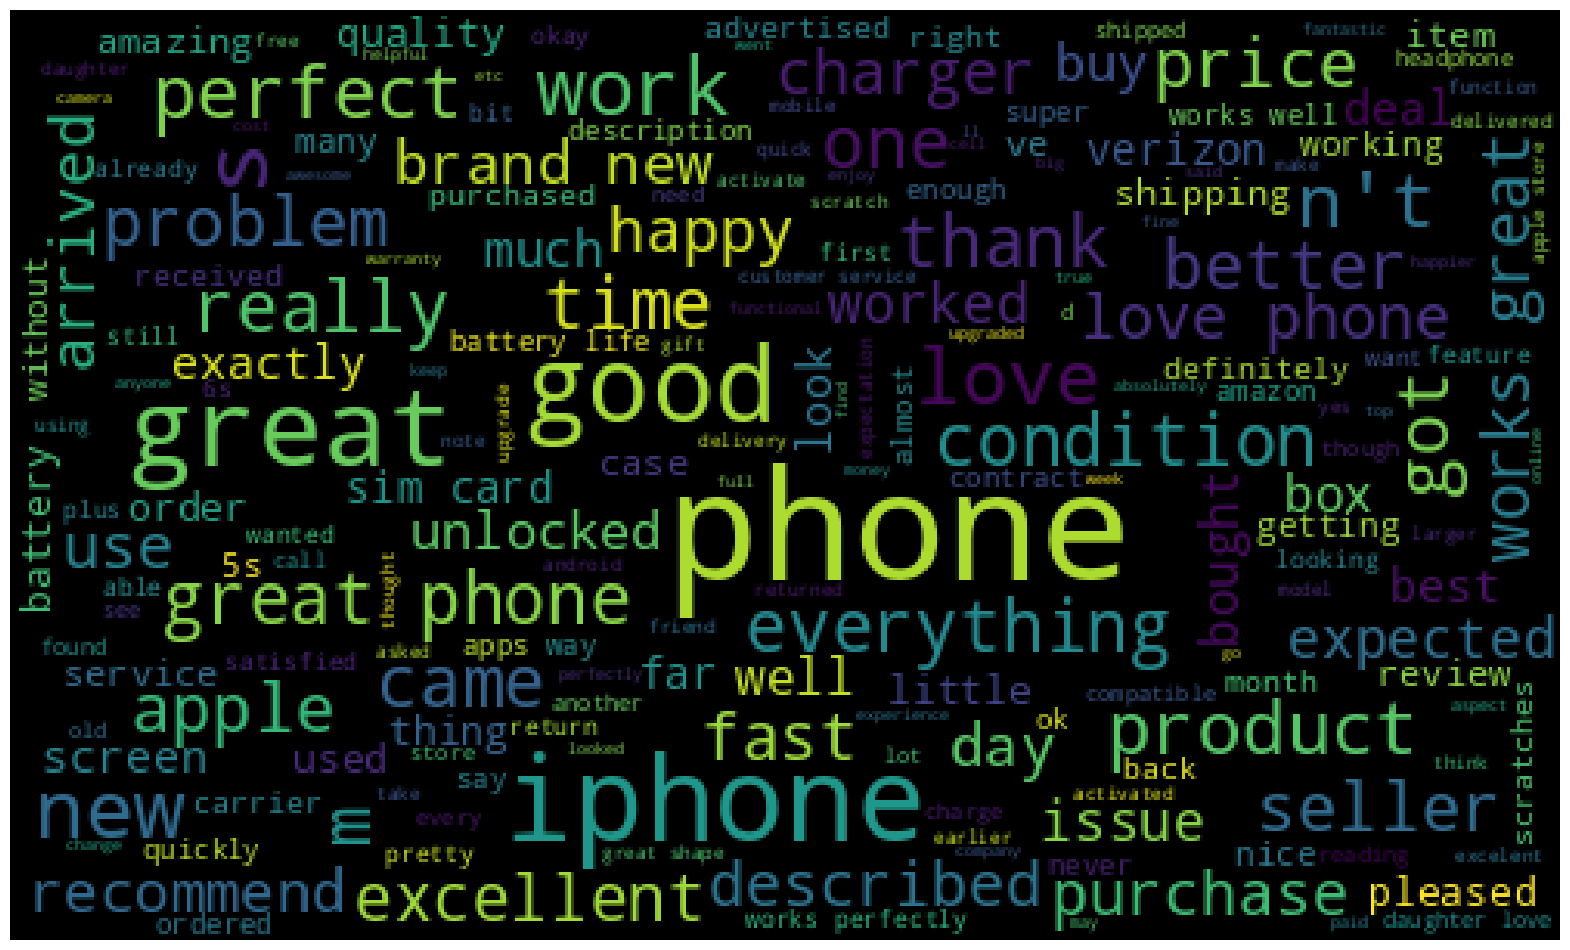

In [80]:
create_word_cloud(brand='Apple', sentiment=1)